# Train a Model with SageMaker AutoPilot
We will use AutoPilot to predict sentiment of customer reviews.

# Introduction

Amazon SageMaker Autopilot is a service to perform automated machine learning (AutoML) on your datasets.  AutoPilot is available through the UI or AWS SDK.  In this notebook, we will use the AWS SDK to create and deploy a text processing and sentiment classification machine learning pipeline.

# Setup

Let's start by specifying:

* The S3 bucket and prefix to use to train our model.  _Note:  This should be in the same region as this notebook._
* The IAM role of this notebook needs access to your data.

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Retreive the S3 Location of the Train Dataset from the Previous Notebook

In [2]:
%store -r train_s3_uri

print(train_s3_uri)

s3://sagemaker-us-west-2-478630443205/data/train.csv


In [3]:
print(train_s3_uri)

!aws s3 ls $train_s3_uri

s3://sagemaker-us-west-2-478630443205/data/train.csv
2020-03-21 16:11:35   34734959 train.csv


# Setup the S3 Location for the AutoPilot-Generated Assets 
This include Jupyter Notebooks (Analysis), Python Scripts (Feature Engineering), and Trained Models.

In [4]:
prefix_model_output = 'models/autopilot'

autopilot_model_output_s3_uri = 's3://{}/{}'.format(bucket, prefix_model_output)

print(autopilot_model_output_s3_uri)


s3://sagemaker-us-west-2-478630443205/models/autopilot


In [5]:
max_candidates = 3

job_config = {
    'CompletionCriteria': {
      'MaxRuntimePerTrainingJobInSeconds': 600,
      'MaxCandidates': max_candidates,
      'MaxAutoMLJobRuntimeInSeconds': 3600
    },
}

input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': '{}'.format(train_s3_uri)
        }
      },
      'TargetAttributeName': 'is_positive_sentiment'
    }
]

output_data_config = {
    'S3OutputPath': '{}'.format(autopilot_model_output_s3_uri)
}

# Launch the SageMaker AutoPilot job

We can now launch the job by calling the `create_auto_ml_job` API.

In [6]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-dm-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

AutoMLJobName: automl-dm-21-16-42-17


_Note that we are not specifying the `ProblemType`.  AutoPilot will automatically detect if we're using regression or classification (binary or multi-class)._

In [7]:
sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig=job_config,
#                      ProblemType="Classification",
                      RoleArn=role)

{'AutoMLJobArn': 'arn:aws:sagemaker:us-west-2:478630443205:automl-job/automl-dm-21-16-42-17',
 'ResponseMetadata': {'RequestId': '60f6204d-4cb3-4818-a288-aaedf6d698c3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '60f6204d-4cb3-4818-a288-aaedf6d698c3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '92',
   'date': 'Sat, 21 Mar 2020 16:42:19 GMT'},
  'RetryAttempts': 0}}

# Tracking the progress of the AutoPilot job
SageMaker AutoPilot job consists of the following high-level steps: 
* _Data Analysis_ where the data is summarized and analyzed to determine which feature engineering techniques, hyper-parameters, and models to explore.
* _Feature Engineering_ where the data is scrubbed, balanced, combined, and split into train and validation
* _Model Training and Tuning_ where the top performing features, hyper-parameters, and models are selected and trained.

# Analyzing Data

In [8]:
# Sleep for a bit to ensure the AutoML job above has time to start
import time
time.sleep(3)

job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job['AutoMLJobStatus']
job_sec_status = job['AutoMLJobSecondaryStatus']

if job_status not in ('Stopped', 'Failed'):
    while job_status in ('InProgress') and job_sec_status in ('AnalyzingData'):
        job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job['AutoMLJobStatus']
        job_sec_status = job['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        sleep(30)
    print("Data analysis complete")
    
print(job)

InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress FeatureEngineering
Data analysis complete
{'AutoMLJobName': 'automl-dm-21-16-42-17', 'AutoMLJobArn': 'arn:aws:sagemaker:us-west-2:478630443205:automl-job/automl-dm-21-16-42-17', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-west-2-478630443205/data/train.csv'}}, 'TargetAttributeName': 'is_positive_sentiment'}], 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-west-2-478630443205/models/autopilot'}, 'RoleArn': 'arn:aws:iam::478630443205:role/TeamRole', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 3, 'MaxRuntimePerTrainingJobIn

## View Generated Notebooks
Once data analysis is complete, SageMaker AutoPilot generates two notebooks: 
* Data exploration,
* Candidate definition.

In [9]:
job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print(job)

{'AutoMLJobName': 'automl-dm-21-16-42-17', 'AutoMLJobArn': 'arn:aws:sagemaker:us-west-2:478630443205:automl-job/automl-dm-21-16-42-17', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-west-2-478630443205/data/train.csv'}}, 'TargetAttributeName': 'is_positive_sentiment'}], 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-west-2-478630443205/models/autopilot'}, 'RoleArn': 'arn:aws:iam::478630443205:role/TeamRole', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 3, 'MaxRuntimePerTrainingJobInSeconds': 600, 'MaxAutoMLJobRuntimeInSeconds': 3600}}, 'CreationTime': datetime.datetime(2020, 3, 21, 16, 42, 19, 736000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 3, 21, 16, 50, 22, 576000, tzinfo=tzlocal()), 'AutoMLJobStatus': 'InProgress', 'AutoMLJobSecondaryStatus': 'FeatureEngineering', 'GenerateCandidateDefinitionsOnly': False, 'AutoMLJobArtifacts': {'CandidateDefinitionNotebookLocation': 's3://sag

## Copy the Generated Notebooks and Scripts Locally

In [10]:
generated_resources = job['AutoMLJobArtifacts']['DataExplorationNotebookLocation'].rstrip('notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb')
generated_resources

's3://sagemaker-us-west-2-478630443205/models/autopilot/automl-dm-21-16-42-17/sagemaker-automl-candidates/pr-1-19d528f1fe414d298cb9423129f233ea3691f8e548ef46cebabb72c'

In [11]:
!rm -rf ./generated_module
!rm -rf ./notebooks
!aws s3 cp --recursive $generated_resources .

## In the file view, open the `notebooks/` and `generated_module/` folders. 
Lots of useful information in these folders ^^

# Feature Engineering

In [12]:
job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job['AutoMLJobStatus']
job_sec_status = job['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    while job_status in ('InProgress') and job_sec_status in ('FeatureEngineering'):
        job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job['AutoMLJobStatus']
        job_sec_status = job['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        sleep(30)
    print("Feature engineering complete")
    
print(job)

Completed
MaxCandidatesReached
Feature engineering complete
{'AutoMLJobName': 'automl-dm-21-16-42-17', 'AutoMLJobArn': 'arn:aws:sagemaker:us-west-2:478630443205:automl-job/automl-dm-21-16-42-17', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-west-2-478630443205/data/train.csv'}}, 'TargetAttributeName': 'is_positive_sentiment'}], 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-west-2-478630443205/models/autopilot'}, 'RoleArn': 'arn:aws:iam::478630443205:role/TeamRole', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 3, 'MaxRuntimePerTrainingJobInSeconds': 600, 'MaxAutoMLJobRuntimeInSeconds': 3600}}, 'CreationTime': datetime.datetime(2020, 3, 21, 16, 42, 19, 736000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2020, 3, 21, 17, 1, 4, 170000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 3, 21, 17, 1, 4, 205000, tzinfo=tzlocal()), 'BestCandidate': {'CandidateName': 'tuning-job-1-06c264e52ee

# Model Training and Tuning

In [13]:
job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job['AutoMLJobStatus']
job_sec_status = job['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    while job_status in ('InProgress') and job_sec_status in ('ModelTuning'):
        job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job['AutoMLJobStatus']
        job_sec_status = job['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        sleep(30)
    print("Model tuning complete")
    
print(job)

Completed
MaxCandidatesReached
Model tuning complete
{'AutoMLJobName': 'automl-dm-21-16-42-17', 'AutoMLJobArn': 'arn:aws:sagemaker:us-west-2:478630443205:automl-job/automl-dm-21-16-42-17', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-west-2-478630443205/data/train.csv'}}, 'TargetAttributeName': 'is_positive_sentiment'}], 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-west-2-478630443205/models/autopilot'}, 'RoleArn': 'arn:aws:iam::478630443205:role/TeamRole', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 3, 'MaxRuntimePerTrainingJobInSeconds': 600, 'MaxAutoMLJobRuntimeInSeconds': 3600}}, 'CreationTime': datetime.datetime(2020, 3, 21, 16, 42, 19, 736000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2020, 3, 21, 17, 1, 4, 170000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 3, 21, 17, 1, 4, 205000, tzinfo=tzlocal()), 'BestCandidate': {'CandidateName': 'tuning-job-1-06c264e52ee342af8a

# Viewing All Candidates
Once model tuning is complete, you can view all the candidates (pipeline evaluations with different hyperparameter combinations) that were explored by AutoML and sort them by their final performance metric.

In [14]:
candidates = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name, 
                                                SortBy='FinalObjectiveMetricValue')['Candidates']
for index, candidate in enumerate(candidates):
    print(str(index) + "  " 
        + candidate['CandidateName'] + "  " 
        + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))

0  tuning-job-1-06c264e52ee342af8a-001-50efc7cd  0.8573060035705566
1  tuning-job-1-06c264e52ee342af8a-002-81d6c26f  0.6181219816207886
2  tuning-job-1-06c264e52ee342af8a-003-c7a29789  0.6181219816207886


# Inspect Trials using Experiments API
SageMaker AutoPilot automatically creates a new experiment, and pushes information for each trial. 

In [15]:
from sagemaker.analytics import ExperimentAnalytics, TrainingJobAnalytics

exp = ExperimentAnalytics(
    sagemaker_session=sess, 
    experiment_name=auto_ml_job_name + '-aws-auto-ml-job',
)

df = exp.dataframe()
df

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,colsample_bytree,...,train:accuracy - Count,SageMaker.ModelName,SageMaker.ModelPrimary.DataUrl,SageMaker.ModelPrimary.Image,processor_module,sagemaker_program,sagemaker_submit_directory,input_channel_mode,job_name,label_col
0,tuning-job-1-06c264e52ee342af8a-001-50efc7cd-a...,tuning-job-1-06c264e52ee342af8a-001-50efc7cd-a...,arn:aws:sagemaker:us-west-2:478630443205:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:accuracy,0.000019,0.379370,...,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tuning-job-1-06c264e52ee342af8a-002-81d6c26f-a...,tuning-job-1-06c264e52ee342af8a-002-81d6c26f-a...,arn:aws:sagemaker:us-west-2:478630443205:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:accuracy,0.000025,0.555207,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tuning-job-1-06c264e52ee342af8a-003-c7a29789-a...,tuning-job-1-06c264e52ee342af8a-003-c7a29789-a...,arn:aws:sagemaker:us-west-2:478630443205:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:accuracy,0.000025,0.555207,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,automl-dm--dpp0-rpb-1-c727b35c0b794f5b8bae2856...,automl-dm--dpp0-rpb-1-c727b35c0b794f5b8bae2856...,arn:aws:sagemaker:us-west-2:478630443205:trans...,NaN,1.0,ml.m5.4xlarge,NaN,NaN,NaN,NaN,...,NaN,automl-dm-21-16-42-17-automl-dm--dpp0-model-48...,s3://sagemaker-us-west-2-478630443205/models/a...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,NaN,NaN,NaN,NaN,NaN,NaN
4,automl-dm--dpp1-csv-1-337f1c604276437e9bdc11c4...,automl-dm--dpp1-csv-1-337f1c604276437e9bdc11c4...,arn:aws:sagemaker:us-west-2:478630443205:trans...,NaN,1.0,ml.m5.4xlarge,NaN,NaN,NaN,NaN,...,NaN,automl-dm-21-16-42-17-automl-dm--dpp1-model-d1...,s3://sagemaker-us-west-2-478630443205/models/a...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,NaN,NaN,NaN,NaN,NaN,NaN
5,automl-dm--dpp0-1-5fc63b23a4fe408cb60801af7374...,automl-dm--dpp0-1-5fc63b23a4fe408cb60801af7374...,arn:aws:sagemaker:us-west-2:478630443205:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,candidate_data_processors.dpp0,candidate_data_processors.trainer,/opt/ml/input/data/code,NaN,NaN,NaN
6,automl-dm--dpp1-1-37ed9a1440334e82bb6901fe2ac5...,automl-dm--dpp1-1-37ed9a1440334e82bb6901fe2ac5...,arn:aws:sagemaker:us-west-2:478630443205:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,candidate_data_processors.dpp1,candidate_data_processors.trainer,/opt/ml/input/data/code,NaN,NaN,NaN
7,db-1-b12c9df78d514b859cce83f3ae64afff3c5566db1...,db-1-b12c9df78d514b859cce83f3ae64afff3c5566db1...,arn:aws:sagemaker:us-west-2:478630443205:proce...,NaN,1.0,ml.m5.2xlarge,250.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pipe,automl-dm-21-16-42-17,is_positive_sentiment


# Explore the Best Candidate
Now that we have successfully completed the AutoML job on our dataset and visualized the trials, we can create a model from any of the trials with a single API call and then deploy that model for online or batch prediction using [Inference Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html). For this notebook, we deploy only the best performing trial for inference.

The best candidate is the one we're really interested in.

In [16]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_identifier = best_candidate['CandidateName']

print("Candidate name: " + best_candidate_identifier)
print("Metric name: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("Metric value: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

Candidate name: tuning-job-1-06c264e52ee342af8a-001-50efc7cd
Metric name: validation:accuracy
Metric value: 0.8573060035705566


In [17]:
best_candidate

{'CandidateName': 'tuning-job-1-06c264e52ee342af8a-001-50efc7cd',
 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:accuracy',
  'Value': 0.8573060035705566},
 'ObjectiveStatus': 'Succeeded',
 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob',
   'CandidateStepArn': 'arn:aws:sagemaker:us-west-2:478630443205:processing-job/db-1-b12c9df78d514b859cce83f3ae64afff3c5566db1bea4aca8e0a29031f',
   'CandidateStepName': 'db-1-b12c9df78d514b859cce83f3ae64afff3c5566db1bea4aca8e0a29031f'},
  {'CandidateStepType': 'AWS::SageMaker::TrainingJob',
   'CandidateStepArn': 'arn:aws:sagemaker:us-west-2:478630443205:training-job/automl-dm--dpp0-1-5fc63b23a4fe408cb60801af737479bfd04606d2e3df4',
   'CandidateStepName': 'automl-dm--dpp0-1-5fc63b23a4fe408cb60801af737479bfd04606d2e3df4'},
  {'CandidateStepType': 'AWS::SageMaker::TransformJob',
   'CandidateStepArn': 'arn:aws:sagemaker:us-west-2:478630443205:transform-job/automl-dm--dpp0-rpb-1-c727b35c0b794f5b8bae2856427fcbf48e98

We can see the containers and models composing the Inference Pipeline.

In [18]:
for container in best_candidate['InferenceContainers']:
    print(container['Image'])
    print(container['ModelDataUrl'])
    print('======================')

246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-sklearn-automl:0.1.0-cpu-py3
s3://sagemaker-us-west-2-478630443205/models/autopilot/automl-dm-21-16-42-17/data-processor-models/automl-dm--dpp0-1-5fc63b23a4fe408cb60801af737479bfd04606d2e3df4/output/model.tar.gz
246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3
s3://sagemaker-us-west-2-478630443205/models/autopilot/automl-dm-21-16-42-17/tuning/automl-dm--dpp0-xgb/tuning-job-1-06c264e52ee342af8a-001-50efc7cd/output/model.tar.gz
246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-sklearn-automl:0.1.0-cpu-py3
s3://sagemaker-us-west-2-478630443205/models/autopilot/automl-dm-21-16-42-17/data-processor-models/automl-dm--dpp0-1-5fc63b23a4fe408cb60801af737479bfd04606d2e3df4/output/model.tar.gz


### Not surprising, AutoPilot has chosen XGBoost as the best model!

Note that AutoPilot chose different hyper-parameters and feature transformations than we used in our own XGBoost model.

# Deploy the Model as a REST Endpoint
Batch transformations are also supported, but for now, we will use a REST Endpoint.

In [19]:
model_name = 'automl-dm-model-' + timestamp_suffix

model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Best candidate model ARN: ', model_arn['ModelArn'])

Best candidate model ARN:  arn:aws:sagemaker:us-west-2:478630443205:model/automl-dm-model-21-16-42-17


In [20]:
# EndpointConfig name
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
epc_name = 'automl-dm-epc-' + timestamp_suffix

# Endpoint name
xgb_endpoint_name = 'automl-dm-ep-' + timestamp_suffix
variant_name = 'automl-dm-variant-' + timestamp_suffix

print(xgb_endpoint_name)
print(variant_name)

automl-dm-ep-21-17-16-15
automl-dm-variant-21-17-16-15


In [21]:
ep_config = sm.create_endpoint_config(EndpointConfigName = epc_name,
                                      ProductionVariants=[{'InstanceType':'ml.m4.xlarge',
                                                           'InitialInstanceCount': 1,
                                                           'ModelName': model_name,
                                                           'VariantName': variant_name}])


In [22]:
create_endpoint_response = sm.create_endpoint(EndpointName=xgb_endpoint_name,
                                              EndpointConfigName=epc_name)
print(create_endpoint_response['EndpointArn'])

arn:aws:sagemaker:us-west-2:478630443205:endpoint/automl-dm-ep-21-17-16-15


# Wait for the Model to Deploy
This may take 5-10 mins.  Please be patient.

In [23]:
sm.get_waiter('endpoint_in_service').wait(EndpointName=xgb_endpoint_name)

In [24]:
resp = sm.describe_endpoint(EndpointName=xgb_endpoint_name)
status = resp['EndpointStatus']

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Arn: arn:aws:sagemaker:us-west-2:478630443205:endpoint/automl-dm-ep-21-17-16-15
Status: InService


# Test Our Model with Some Example Reviews
Let's do some ad-hoc predictions on our model.

In [25]:
sm_runtime = boto3.client('sagemaker-runtime')

In [26]:
csv_line_predict_positive = """I loved it!  I will recommend this to everyone."""

response = sm_runtime.invoke_endpoint(EndpointName=xgb_endpoint_name, ContentType='text/csv', Accept='text/csv', Body=csv_line_predict_positive)

response_body = response['Body'].read().decode('utf-8').strip()
response_body

'1'

In [27]:
csv_line_predict_negative = """Really bad.  I hope they stop making this."""

response = sm_runtime.invoke_endpoint(EndpointName=xgb_endpoint_name, ContentType='text/csv', Accept='text/csv', Body=csv_line_predict_negative)

response_body = response['Body'].read().decode('utf-8').strip()
response_body

'0'

# Calculate Full Test Metrics
Let's compute full test metrics using our holdout `test` dataset.

## Load the Test Data

In [28]:
test_path = './data/test.csv'

In [29]:
ls -al $test_path

-rw-rw-r-- 1 ec2-user ec2-user 3870626 Mar 21 16:11 ./data/test.csv


In [30]:
def load_dataset(path, sep, header):
    data = pd.read_csv(path, sep=sep, header=header)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [31]:
X_test, y_test = load_dataset(path=test_path, sep=',', header=0)
X_test.shape

(10209, 1)

In [32]:
X_test.head(5)

,review_body
0,H&R Block tax software is cheaper than the Tur...
1,Works fine!
2,So far so good. Im liking it. Better than avg.
3,"Do Not Waste Your Money. Unfortunately, I rar..."
4,Download version keeps asking for CD and does ...


In [33]:
y_test.shape

(10209,)

In [34]:
y_test.head(5)

0    1
1    1
2    1
3    0
4    0
Name: is_positive_sentiment, dtype: int64

## Invoke the Endpoint with our Test Dataset

In [35]:
payload = X_test.to_csv(index=False, header=False).rstrip()

response = sm_runtime.invoke_endpoint(EndpointName=xgb_endpoint_name, 
                                                  Body=payload.encode('utf-8'),
                                                  ContentType='text/csv')['Body'].read().decode('utf-8').strip()
response

'1\n1\n1\n0\n0\n1\n1\n1\n1\n0\n1\n1\n1\n0\n1\n1\n1\n1\n0\n1\n1\n1\n1\n1\n0\n1\n1\n1\n0\n0\n0\n1\n0\n0\n1\n1\n0\n0\n1\n0\n0\n1\n0\n1\n1\n0\n0\n1\n1\n1\n1\n1\n1\n0\n1\n1\n1\n1\n1\n1\n0\n1\n0\n0\n0\n1\n0\n1\n0\n0\n1\n1\n1\n1\n1\n0\n1\n1\n0\n0\n1\n0\n1\n1\n1\n1\n1\n1\n1\n1\n1\n0\n1\n0\n1\n1\n1\n0\n0\n0\n1\n1\n0\n1\n1\n0\n0\n1\n1\n1\n0\n0\n1\n1\n1\n1\n1\n1\n0\n1\n0\n1\n0\n1\n0\n1\n1\n1\n0\n0\n1\n1\n0\n1\n1\n1\n1\n0\n1\n1\n1\n0\n0\n1\n1\n1\n1\n1\n1\n0\n1\n1\n1\n1\n0\n1\n1\n0\n0\n0\n0\n1\n1\n0\n1\n1\n0\n0\n1\n1\n1\n1\n0\n0\n0\n0\n1\n1\n1\n1\n1\n1\n0\n1\n0\n1\n1\n0\n1\n1\n0\n0\n0\n1\n1\n1\n1\n1\n1\n1\n0\n1\n0\n0\n0\n0\n0\n1\n0\n1\n0\n1\n1\n0\n0\n1\n0\n1\n1\n0\n0\n1\n1\n1\n1\n0\n0\n1\n1\n0\n1\n1\n1\n1\n0\n1\n1\n1\n1\n0\n1\n0\n1\n0\n0\n1\n0\n0\n1\n0\n0\n0\n1\n1\n1\n1\n1\n0\n1\n1\n1\n1\n1\n1\n0\n1\n1\n0\n0\n0\n0\n0\n1\n1\n1\n1\n1\n1\n0\n1\n1\n0\n0\n1\n0\n0\n1\n1\n1\n0\n1\n0\n1\n1\n0\n0\n1\n0\n0\n1\n1\n1\n0\n0\n1\n1\n1\n1\n0\n1\n0\n1\n1\n0\n1\n1\n0\n1\n0\n1\n1\n1\n1\n1\n0\n1\n1\n1\n0\n0\n1\n1\n1\n

In [36]:
import numpy as np

preds_test = np.fromstring(response, sep='\n')
preds_test.shape

(10209,)

In [37]:
preds_test

array([1., 1., 1., ..., 0., 1., 1.])

## Analyze and Visualize Our Test Metrics

In [38]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test))
print('Test Precision: ', precision_score(y_test, preds_test, average=None))

Test Accuracy:  0.8570868841218533
Test Precision:  [0.81700026 0.88132663]


In [39]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test, preds_test)
df_cm_test

array([[3143,  755],
       [ 704, 5607]])

[[3143  755]
 [ 704 5607]]


<Figure size 432x288 with 0 Axes>

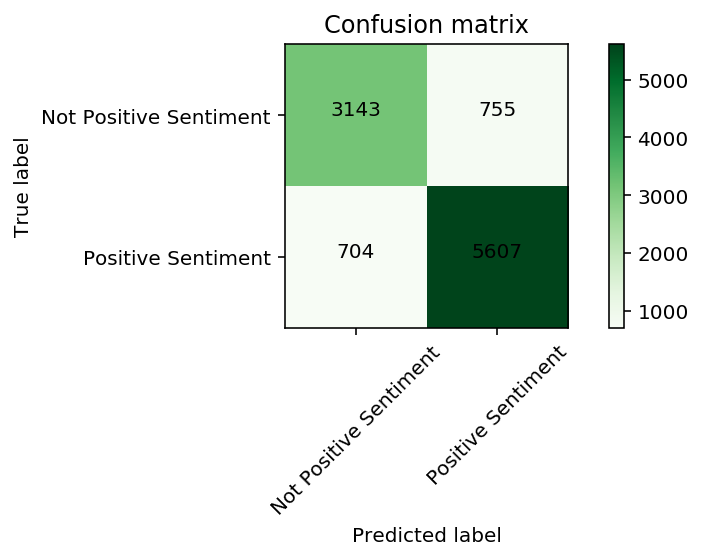

In [40]:
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

AUC is 0.8474


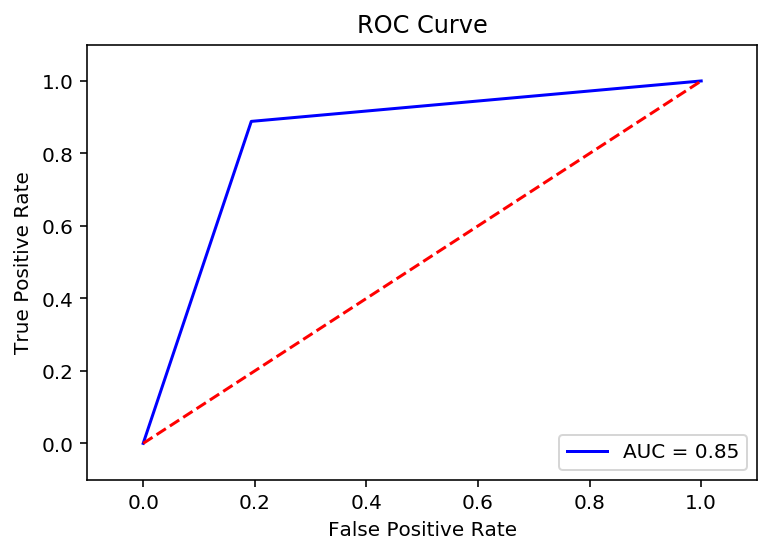

In [41]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Summary
We used AutoPilot to automatically find the best model, hyper-parameters, and feature-engineering scripts for our dataset.  

AutoPilot uses a white-box approach to generate re-usable exploration Jupyter Notebooks and transformation Python scripts to continue to train and deploy our model on new data - well after this initial interaction with the AutoPilot service.